In [42]:
import sys
sys.path.append('/workspaces/secure_inference/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import os

from research.distortion.parameters.classification.resent.resnet18_8xb16_cifar100 import Params as resnet18_8xb16_cifar100_Params

In [8]:
dims = resnet18_8xb16_cifar100_Params().LAYER_NAME_TO_DIMS

In [10]:
with open('/workspaces/secure_inference/tests/distortion_extraction_22_11_512/block_spec/0.08.pickle', 'rb') as f:
    knapsack = pkl.load(f)

def get_amounts(blocks, dims):
    full_amount = dims[1] * dims[2]
    blocks_area =  np.prod(blocks, axis=1)
    blocks_amount = np.where(blocks_area == 0, 0, full_amount / blocks_area)
    return blocks_amount

prev_amounts = {name: get_amounts(blocks, dims[name]) for name, blocks in knapsack.items()}
prev_amounts

/tmp/ipykernel_10424/2585201312.py:7: RuntimeWarning: divide by zero encountered in true_divide
  blocks_amount = np.where(blocks_area == 0, 0, full_amount / blocks_area)


{'stem': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , 21.33333333,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 85.33333333,
         0.        ,  0.        , 20.89795918,  0.        ,  0.        ,
         0.        , 64.        ,  0.        ,  0.        , 64.        ,
         0.        , 64.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 10.66666667,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 32.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , 56.88888889,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 16.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]),
 'layer1_0_1': array([  1.        ,   0.        ,   0.

In [14]:
base_dir = '/workspaces/secure_inference/tests/22_cluster_amount_stats'
stats = {}
for sub_dir in os.listdir(base_dir):
    file_path = os.path.join(base_dir, sub_dir, 'per_channel.csv')
    stats[sub_dir] = pd.read_csv(file_path)




In [19]:
all_stats = [cur_stats.assign(pref=name.split('_')[-1]) for name, cur_stats in stats.items()]
all_stats = pd.concat(all_stats)
all_stats

,batch_index,layer_name,channel,id,channels,all_zero,failed_to_converge,cluster_amount,same_label_affinity,diff_label_affinity,prototype_affinity,drelu_mean,pref
0,28,stem,0,0,[0],True,False,NaN,0.000000,0.000000,0.000000,0.000000,0.1
1,28,stem,1,1,[1],False,False,96.0,-0.033742,-0.105127,-0.026202,0.914389,0.1
2,28,stem,2,2,[2],True,False,NaN,0.000000,0.000000,0.000000,0.000000,0.1
3,28,stem,3,3,[3],True,False,NaN,0.000000,0.000000,0.000000,0.000000,0.1
4,28,stem,4,4,[4],False,False,75.0,-0.148749,-0.255594,-0.095160,0.850488,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128827,284,layer4_1_2,507,507,[507],False,False,16.0,0.000000,-0.187882,0.000000,0.580872,0.95
128828,284,layer4_1_2,508,508,[508],False,False,16.0,0.000000,-0.189160,0.000000,0.570312,0.95
128829,284,layer4_1_2,509,509,[509],False,False,16.0,0.000000,-0.195369,0.000000,0.602234,0.95
128830,284,layer4_1_2,510,510,[510],False,False,16.0,0.000000,-0.207837,0.000000,0.580994,0.95


In [30]:
all_stats['pref'] = all_stats['pref'].apply(lambda x: round(float(x), 2))
last_batch = all_stats.query('batch_index == 284 and (not failed_to_converge)')

In [39]:
last_batch.query('pref == 0.9 & layer_name == "layer4_0_1"')['cluster_amount'].max()

14.0

In [100]:
np.count_nonzero(knapsack['layer3_0_1'][:, 0] == 0)

36

In [101]:
31 / 64 - (36/256)

0.34375

In [55]:
prev_amounts_df = pd.DataFrame([(key, idx, value) for key, arr in prev_amounts.items() for idx, value in enumerate(arr)], 
                  columns=['layer_name', 'channel', 'cluster_amount'])
prev_amounts_df['pref'] = 'knapsack'

In [86]:
matches = []
for layer_name, layer_prev_amounts in prev_amounts.items():
    C, H, W = dims[layer_name]
    for channel in range(C):
        prev_amount = layer_prev_amounts[channel]
        match = {'layer_name': layer_name, 'channel': channel, 'knapsack_amount': prev_amount}
        if prev_amount == 0:
            match['pref'] = 'id'
            match['cur_amount'] = prev_amount
        elif prev_amount == C * H * W:
            match['pref'] = 'relu'
            match['cur_amount'] = prev_amount
        else:
            clustering_amounts = last_batch.query('channel == @channel & layer_name == @layer_name').copy()
            clustering_amounts = clustering_amounts.reset_index()
            clustering_amounts['clustering_dist'] = (clustering_amounts['cluster_amount'] - prev_amount).abs() - clustering_amounts['pref']
            closest_row = clustering_amounts.loc[clustering_amounts['clustering_dist'].idxmin()]
            match.update({'pref': closest_row['pref'], 'cur_amount': closest_row['cluster_amount']})
        matches.append(match)

In [89]:
matches = pd.DataFrame(matches)
matches

,layer_name,channel,knapsack_amount,pref,cur_amount
0,stem,0,0.0,id,0.0
1,stem,1,0.0,id,0.0
2,stem,2,0.0,id,0.0
3,stem,3,0.0,id,0.0
4,stem,4,0.0,id,0.0
...,...,...,...,...,...
3899,layer4_1_2,507,1.0,0.15,3.0
3900,layer4_1_2,508,1.0,0.6,4.0
3901,layer4_1_2,509,1.0,0.15,3.0
3902,layer4_1_2,510,1.0,0.15,3.0


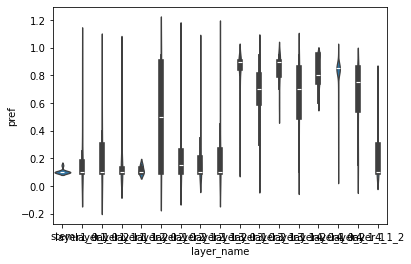

In [91]:
sns.violinplot(x='layer_name', y='pref', 
            #    ax=axs[layer_idx][block_idx], 
                data=matches.query('pref not in ["id", "relu"]'))
plt.show()

In [88]:
total_size = sum(d[0]*d[1]*d[2] for d in dims.values())
knapsack_size = m['knapsack_amount'].sum()
cluster_size = m['cur_amount'].sum()
print(knapsack_size / total_size)
print(cluster_size / total_size)

0.0786059174646421
0.0908346737132353


In [ ]:
clustering_amounts['clustering_dist'].idxmin()

,layer_name,channel,knapsack_amount,pref,cur_amount
0,stem,0,0.0,id,0.0
1,stem,1,0.0,id,0.0
2,stem,2,0.0,id,0.0
3,stem,3,0.0,id,0.0
4,stem,4,0.0,id,0.0
...,...,...,...,...,...
3899,layer4_1_2,507,1.0,128827 0.10 128827 0.15 128827 0.20 1...,128827 3.0 128827 3.0 128827 4.0 1...
3900,layer4_1_2,508,1.0,128828 0.10 128828 0.15 128828 0.20 1...,128828 4.0 128828 4.0 128828 4.0 1...
3901,layer4_1_2,509,1.0,128829 0.10 128829 0.15 128829 0.20 1...,128829 3.0 128829 3.0 128829 4.0 1...
3902,layer4_1_2,510,1.0,128830 0.10 128830 0.15 128830 0.20 1...,128830 3.0 128830 3.0 128830 4.0 1...


In [67]:
print(prev_amount)
clustering_amounts['']

1.0


,batch_index,layer_name,channel,id,channels,all_zero,failed_to_converge,cluster_amount,same_label_affinity,diff_label_affinity,prototype_affinity,drelu_mean,pref,clustering_dist
128320,284,layer4_1_2,0,0,[0],False,False,3.0,-0.111735,-0.217236,-0.097900,0.574585,0.10,3.0
128320,284,layer4_1_2,0,0,[0],False,False,4.0,-0.091248,-0.206055,-0.078125,0.574585,0.15,4.0
128320,284,layer4_1_2,0,0,[0],False,False,4.0,-0.091553,-0.206156,-0.078247,0.574463,0.20,4.0
128320,284,layer4_1_2,0,0,[0],False,False,4.0,-0.091553,-0.206401,-0.078247,0.574463,0.25,4.0
128320,284,layer4_1_2,0,0,[0],False,False,4.0,-0.091583,-0.206014,-0.078430,0.574768,0.30,4.0
128320,284,layer4_1_2,0,0,[0],False,False,4.0,-0.091431,-0.206116,-0.078247,0.574463,0.35,4.0
128320,284,layer4_1_2,0,0,[0],False,False,4.0,-0.091492,-0.206502,-0.078247,0.574463,0.40,4.0
128320,284,layer4_1_2,0,0,[0],False,False,4.0,-0.091278,-0.205851,-0.078064,0.574524,0.45,4.0
128320,284,layer4_1_2,0,0,[0],False,False,4.0,-0.091187,-0.206116,-0.078125,0.574463,0.50,4.0
128320,284,layer4_1_2,0,0,[0],False,False,4.0,-0.091431,-0.206095,-0.078003,0.574463,0.55,4.0


stem


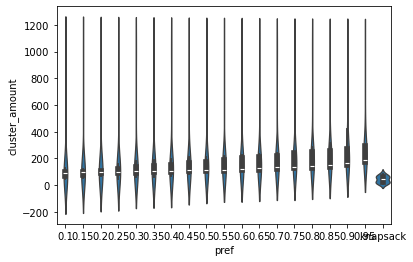

layer1_0_1


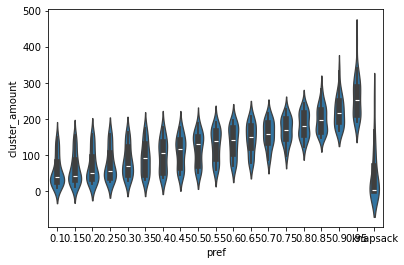

layer1_0_2


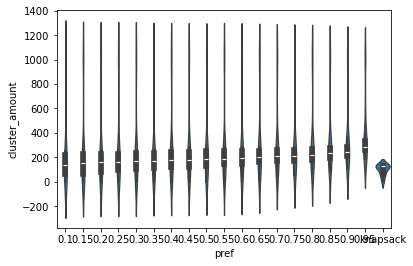

layer1_1_1


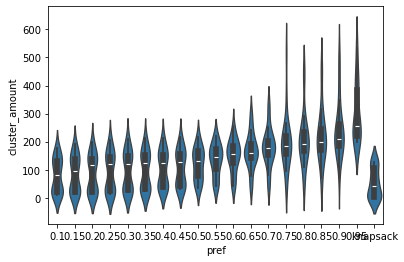

layer1_1_2


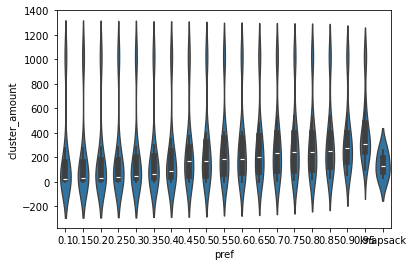

layer2_0_1


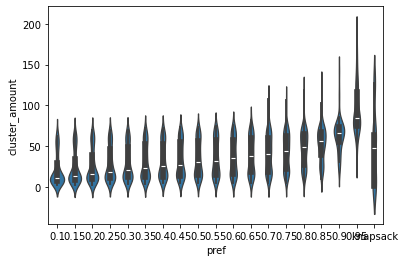

layer2_0_2


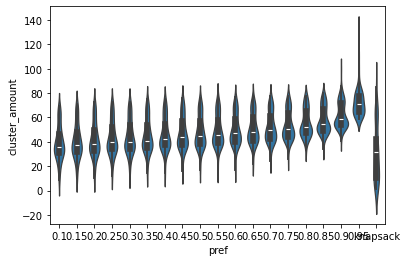

layer2_1_1


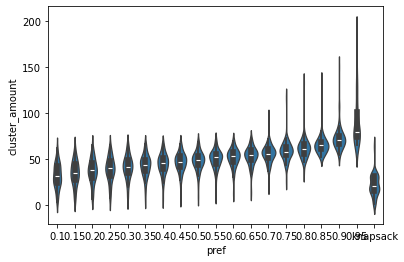

layer2_1_2


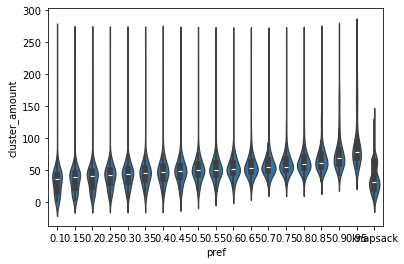

layer3_0_1


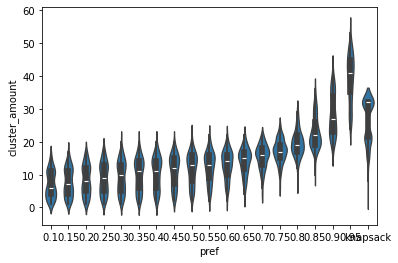

layer3_0_2


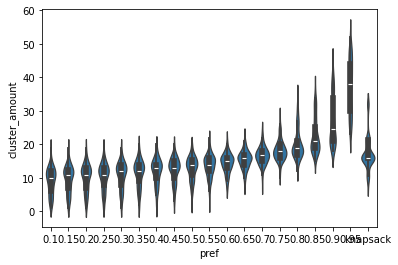

layer3_1_1


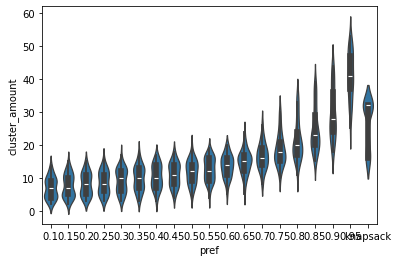

layer3_1_2


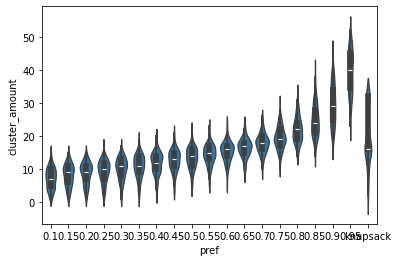

layer4_0_1


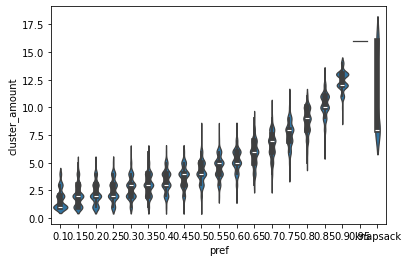

layer4_0_2


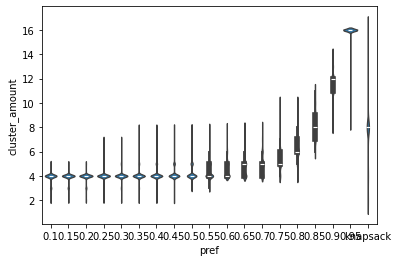

layer4_1_1


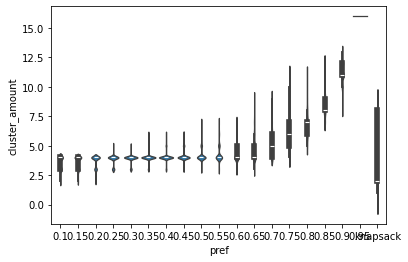

layer4_1_2


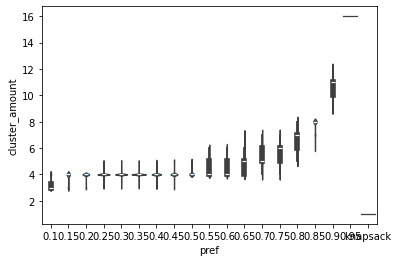

In [57]:
# Create violin plots
# f, axs = plt.subplots(4, 4)
for layer_name in dims:
    layer_res = last_batch.query('layer_name == @layer_name and (not all_zero)')
    prev_layer_df = prev_amounts_df.query('layer_name == @layer_name and cluster_amount > 0')
    combined = pd.concat([layer_res, prev_layer_df])
    print(layer_name)
    combined_df = prev_amounts[layer_name]
    sns.violinplot(x='pref', y='cluster_amount', 
                #    ax=axs[layer_idx][block_idx], 
                    data=combined)
    
    # axs[layer_idx][block_idx].set_title(layer_name)
    plt.show()